Scratch Jupyter Noteboook

In [1]:
import numpy as np
from numpy.typing import NDArray
import matplotlib.pyplot as plt
from matplotlib import cm
import tqdm  
import activations
import params
import inference
import training
%matplotlib inline
from importlib import reload


# Parameters

In [2]:

import activations
from params import FlattenOrder

nonlinear_params = {
    'alpha': 900,
    'beta':  -.06045,
    'r': 3.99,
    'mu': 1.99
}

num_samples_train = 10000
num_samples_test = 1000


config = params.RegressionParams(
    width = 1000,
    depth = 50,
    input_dimension = 2,
    transform_type = activations.TransformType.TENT,
    transform_params = params.TentParams(
        mu = 1.99
    ), 
    output_dimension=1,
    flatten_order=FlattenOrder.AUTO
)

# Function Definitions

In [3]:

def xor(x: NDArray) -> int:

    if x[0] >= 0:
        # First or Fourth Quadrants
        if x[1] >= 0:
            # First Quadrant
                return 0
            # Fourth Quadrant
        else:
            return 1
        
    # Second or Third Quadrants
    else:
        # Second Quadrant
        if x[1] >= 0:
            return 1
        
        # Fourth Quadrant
        else:
            return 0

# Neuron Preferred Directions

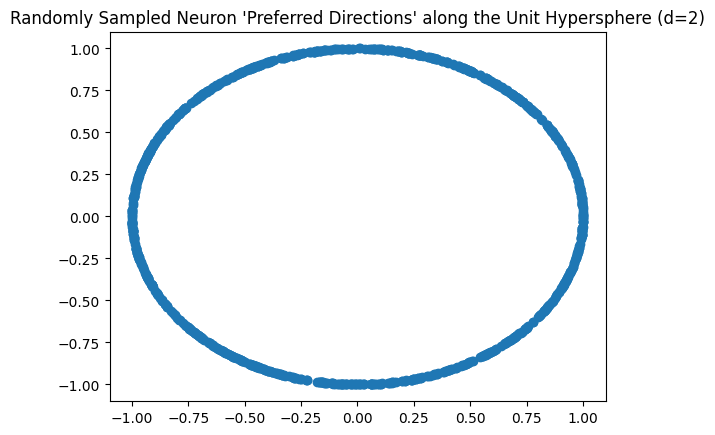

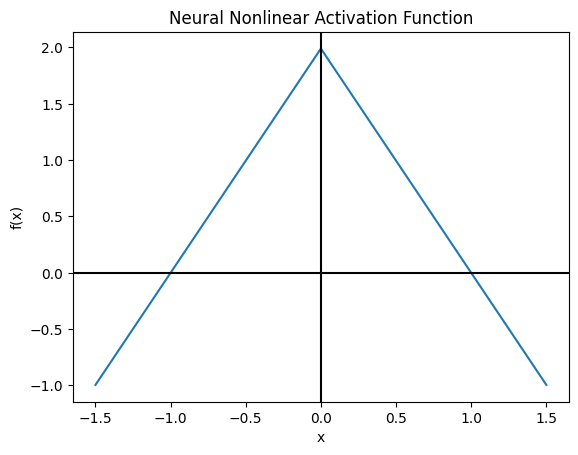

In [4]:
neurons = np.random.normal(loc=0, scale=1, size=(config.input_dimension, config.width))
neurons = neurons / np.linalg.norm(neurons, axis=0)
neurons = np.asarray(neurons)
plt.scatter(neurons[0,:], neurons[1,:])
plt.title("Randomly Sampled Neuron 'Preferred Directions' along the Unit Hypersphere (d=2)")
plt.show()

plt.title("Neural Nonlinear Activation Function")
xs = np.asarray(np.linspace(-1.5, 1.5, num=1000))
# plt.plot(xs, gauss(xs, alpha=nonlinear_params['alpha'], beta=nonlinear_params['beta']))
plt.plot(xs, activations.tent(xs, params=config.transform_params))

# plt.xlim([-1, 1])
# plt.ylim(-1,1)
plt.xlabel("x")
plt.axhline(0, c='k')
plt.axvline(0, c='k')
plt.ylabel("f(x)")
plt.show()


# Topological Mixing

/tmp/ipykernel_805/1203728560.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('inferno', config.depth+1)
/tmp/ipykernel_805/1203728560.py:9: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(activations_identity[idx_layer, :, 0], activations_identity[idx_layer, :, 1], label=f"Pass {idx_layer+1}", c=colors(idx_layer+1))


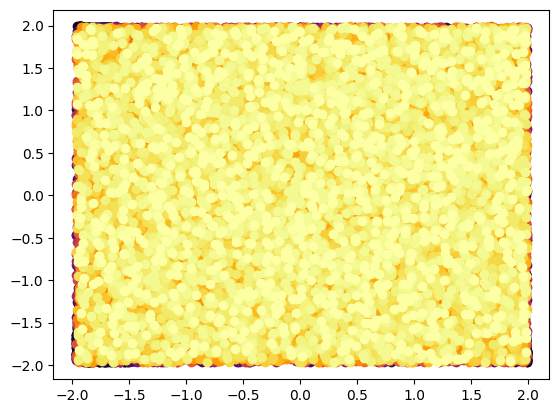

In [5]:
colors = cm.get_cmap('inferno', config.depth+1)


activations_identity = activations.compute_activations(neurons, np.asarray(np.eye(2)), config)


plt.scatter(neurons[0,:], neurons[1,:], color="black")
for idx_layer in range(1,config.depth): 
    plt.scatter(activations_identity[idx_layer, :, 0], activations_identity[idx_layer, :, 1], label=f"Pass {idx_layer+1}", c=colors(idx_layer+1))
    
# plt.xlim([-1.25, 1.25])
# plt.ylim([-1.25, 1.25])
# plt.legend()
plt.show()

# XOR Example 

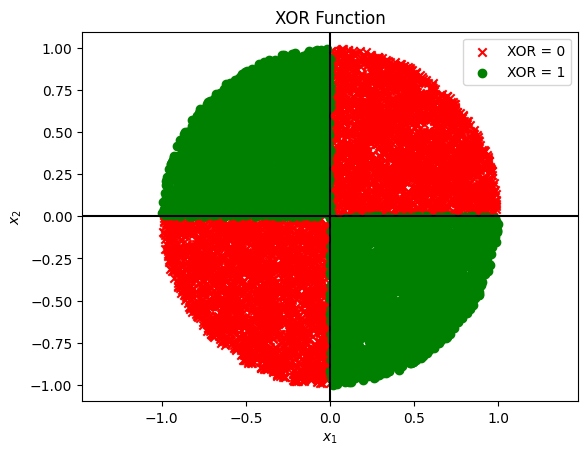

In [6]:



# acts has shape (depth, num_neurons, num_samples)
test_samples = np.random.normal(loc=0, scale=1, size=(config.input_dimension, num_samples_test))
test_samples /= np.linalg.norm(test_samples,axis=0)
train_samples = np.random.normal(loc=0, scale=1, size=(config.input_dimension, num_samples_train))
train_samples /= np.linalg.norm(train_samples,axis=0)

# Scale by radii distributed according to d^th root (where d is dimension) to get uniform density 
test_radii = np.random.uniform(0, 1, size=num_samples_test)
train_radii = np.random.uniform(0, 1, size=num_samples_train)
test_samples *= np.sqrt(test_radii)
train_samples *= np.sqrt(train_radii)


# Batch compute activations
activations_train = activations.compute_activations(neurons, input_x=train_samples, config=config) # np.zeros((n_layers, num_neurons, num_samples_train)) 
activations_test =  activations.compute_activations(neurons, input_x=test_samples, config=config) # np.zeros((n_layers, num_neurons, num_samples_train)) 


# Compute XOR, then use making to plot classification
xors_train = np.expand_dims(np.array([xor(train_samples[:, i]) for i in range(num_samples_train)]), axis=-1)

mask_0 = (xors_train == 0).squeeze()
mask_1 = (xors_train == 1).squeeze()
plt.scatter(train_samples[0,mask_0], train_samples[1,mask_0], c='red', marker='x', label='XOR = 0')
plt.scatter(train_samples[0,mask_1], train_samples[1,mask_1], c='green', marker='o', label='XOR = 1')
        
plt.axis('equal')
plt.axvline(x=0, c='black')
plt.axhline(y=0, c='black')

plt.title("XOR Function")
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend()

    

# Train an XOR Decoder

In [12]:
from importlib import reload
reload(training)
decoders = training.compute_decoders(activations_train, xors_train, config)

100%|██████████| 1000/1000 [00:10<00:00, 99.34it/s]


100%|██████████| 1000/1000 [00:07<00:00, 133.65it/s]


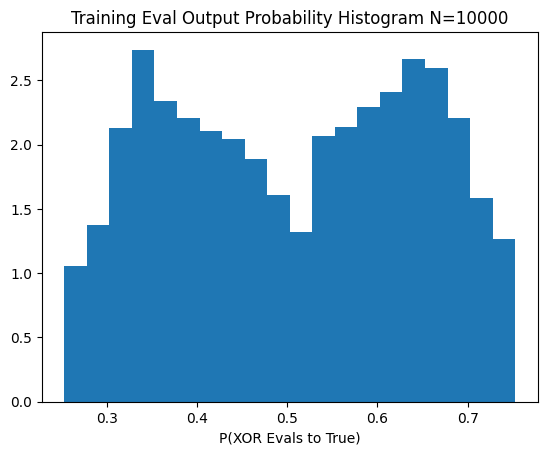

In [ ]:
outputs = inference.infer(train_samples, neurons, decoders, config)
#  (D x S) x (D x Y).T @ (D x S) ==> Y x 
plt.hist(outputs.mean(axis=2).T, 20, density=True)
plt.title(f"Training Eval Output Probability Histogram N={len(xors_train)}")
plt.xlabel("P(XOR Evals to True)")
plt.show()

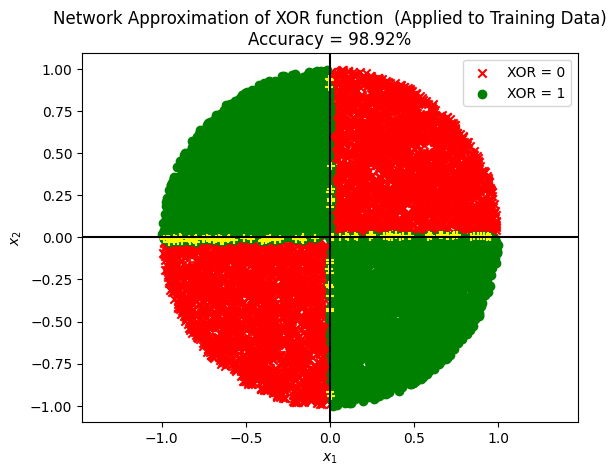

In [16]:
xor_thresh = 0.5 

xors_train_rounded = outputs.mean(axis=2).copy()
xors_train_rounded[xors_train_rounded <= xor_thresh] = 0
xors_train_rounded[xors_train_rounded > xor_thresh] = 1
xor_train_actual = np.array([xor(train_samples[:, i]) for i in range(train_samples.shape[1])])


mask_0 = np.isclose(xors_train_rounded, 0).squeeze()
mask_1 = np.isclose(xors_train_rounded, 1).squeeze()
plt.scatter(train_samples[0,mask_0], train_samples[1,mask_0], c='red', marker='x', label='XOR = 0')
plt.scatter(train_samples[0,mask_1], train_samples[1,mask_1], c='green', marker='o', label='XOR = 1')

mask_incorrect = (xors_train_rounded != xor_train_actual).squeeze()
plt.scatter(train_samples[0,mask_incorrect], train_samples[1,mask_incorrect], marker='+',c='yellow')
        
plt.axis('equal')
plt.axvline(x=0, c='black')
plt.axhline(y=0, c='black')

plt.title(f"Network Approximation of XOR function  (Applied to Training Data)\nAccuracy = {100 *(1 - sum(mask_incorrect)/num_samples_train)}%")
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend()


# Test XOR Approximation

100%|██████████| 1000/1000 [00:02<00:00, 388.67it/s]


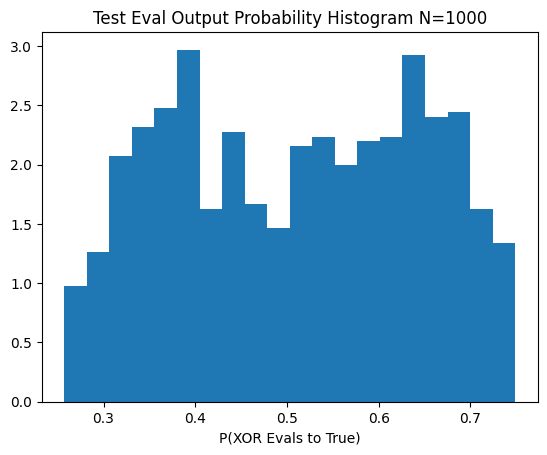

In [18]:
outputs_test = infer(test_samples, neurons, decoders, config)
#  (D x S) x (D x Y).T @ (D x S) ==> Y x 
plt.hist(outputs_test.mean(axis=2).T, 20, density=True)
plt.title(f"Test Eval Output Probability Histogram N={test_samples.shape[1]}")
plt.xlabel("P(XOR Evals to True)")
plt.show()

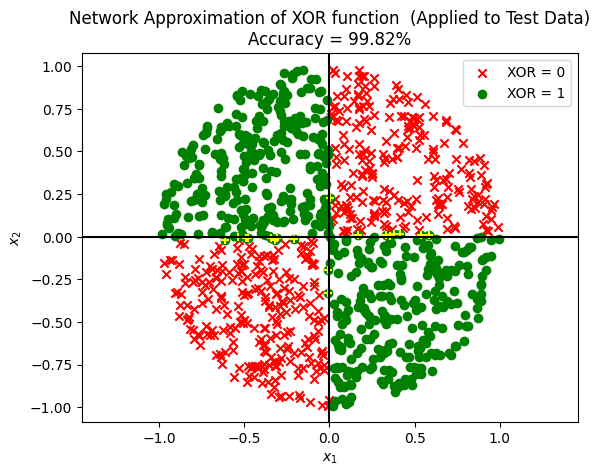

In [19]:
xor_thresh = 0.5 

xors_test_rounded = outputs_test.mean(axis=2).copy()
xors_test_rounded[xors_test_rounded <= xor_thresh] = 0
xors_test_rounded[xors_test_rounded > xor_thresh] = 1
xors_test_actual = np.array([xor(test_samples[:, i]) for i in range(test_samples.shape[1])])


mask_0 = np.isclose(xors_test_rounded, 0).squeeze()
mask_1 = np.isclose(xors_test_rounded, 1).squeeze()
plt.scatter(test_samples[0,mask_0], test_samples[1,mask_0], c='red', marker='x', label='XOR = 0')
plt.scatter(test_samples[0,mask_1], test_samples[1,mask_1], c='green', marker='o', label='XOR = 1')

mask_incorrect = (xors_test_rounded != xors_test_actual).squeeze()
plt.scatter(test_samples[0,mask_incorrect], test_samples[1,mask_incorrect], marker='+',c='yellow')
        
plt.axis('equal')
plt.axvline(x=0, c='black')
plt.axhline(y=0, c='black')

plt.title(f"Network Approximation of XOR function  (Applied to Test Data)\nAccuracy = {100 *(1 - sum(mask_incorrect)/num_samples_train)}%")
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend()